In [170]:
%matplotlib inline
import rebound
import os
import numpy as np
import datetime
import corner
import astropy
from astropy.time import Time
import matplotlib.pyplot as plt

In [171]:
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
event = Time("2013-02-15 03:20:21.1", format="iso", scale="utc")
aa_frame = AltAz(location=EarthLocation(lat=54.4540*u.deg,lon= 64.4739*u.deg), obstime=event)
up = SkyCoord('0deg 90deg',frame=aa_frame, unit=u.deg).transform_to("icrs")
east = SkyCoord('90deg 0deg',frame=aa_frame, unit=u.deg).transform_to("icrs")

In [204]:
# Cache Horizon data
if not os.path.isfile("ss_frame.bin"):
    sim = rebound.Simulation()
    te_tcb = datetime.datetime.strptime(event.tcb.iso[0:19],"%Y-%m-%d %H:%M:%S")
    for p in ["Sun","Mercury","Venus","399", "301", "Mars", "Jupiter", "Saturn"]:
        sim.add(p, date=te_tcb, plane="frame")
    sim.save("ss_frame.bin")

In [240]:
def radec2xyz(ra, dec):
    x = np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra(ra, dec):
    x = -np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddra(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddec(ra, dec):
    x = -np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.pi/180.*np.cos(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dddec(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra_ddec(ra, dec):
    x = np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def mod360(a):
    while a>360.:
        a-=360.
    while a<0.:
        a+=360.
    return a

def run():
    sim = rebound.Simulation.from_file("ss_frame.bin")
    sim.dt = 1e-6
    sim.ri_ias15.min_dt = sim.dt
    
    # Create new meteor particle
    p = sim.particles[3].copy()
    p.m = 0.

    # Velocity of meteor to Earth atmosphere 
    v = 19.03*0.033572943
    vx, vy, vz = -v*radec2xyz(328.12,7.41)
    p.vx += vx; p.vy += vy; p.vz += vz    
    
    # Velocity of Earth atmosphere relative to Earth
    vx, vy, vz = 0.27411473*0.033572943*radec2xyz(east.ra.value, east.dec.value)
    p.vx += vx; p.vy += vy; p.vz += vz

    # Position relative to Earth
    r = 4.2587571e-05 + 6.3503578e-07  # 95km altitude 
    x, y, z = r*radec2xyz(up.ra.value, up.dec.value)
    p.x += x; p.y += y; p.z += z    

    sim.add(p)
    
    # Add variations
    var_dv = sim.add_variation(testparticle=8)
    vx, vy, vz = -radec2xyz(328.12,7.41)
    var_dv.particles[0].vx = vx
    var_dv.particles[0].vy = vy
    var_dv.particles[0].vz = vz

    var_ddv = sim.add_variation(testparticle=8, order=2, first_order=var_dv)
    
    var_dra = sim.add_variation(testparticle=8)
    v = 19.03*0.033572943
    vx, vy, vz = -v*radec2xyz_dra(328.12,7.41)
    var_dra.particles[0].vx = vx
    var_dra.particles[0].vy = vy
    var_dra.particles[0].vz = vz
  
    var_ddra = sim.add_variation(testparticle=8, order=2, first_order=var_dra)
    v = 19.03*0.033572943
    vx, vy, vz = -v*radec2xyz_ddra(328.12,7.41)
    var_ddra.particles[0].vx = vx
    var_ddra.particles[0].vy = vy
    var_ddra.particles[0].vz = vz
   
    var_ddec = sim.add_variation(testparticle=8)
    v = 19.03*0.033572943
    vx, vy, vz = -v*radec2xyz_ddec(328.12,7.41)
    var_ddec.particles[0].vx = vx
    var_ddec.particles[0].vy = vy
    var_ddec.particles[0].vz = vz
    
    var_dddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec)
    v = 19.03*0.033572943
    vx, vy, vz = -v*radec2xyz_dddec(328.12,7.41)
    var_dddec.particles[0].vx = vx
    var_dddec.particles[0].vy = vy
    var_dddec.particles[0].vz = vz
  
    var_dra_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_ddec)
    v = 19.03*0.033572943
    vx, vy, vz = -v*radec2xyz_dra_ddec(328.12,7.41)
    var_dra_ddec.particles[0].vx = vx
    var_dra_ddec.particles[0].vy = vy
    var_dra_ddec.particles[0].vz = vz
  
    var_dv_dra = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_dv)
    vx, vy, vz = -radec2xyz_ddra(328.12,7.41)
    var_dv_dra.particles[0].vx = vx
    var_dv_dra.particles[0].vy = vy
    var_dv_dra.particles[0].vz = vz

    var_dv_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec, first_order_2=var_dv)
    vx, vy, vz = -radec2xyz_ddec(328.12,7.41)
    var_dv_ddec.particles[0].vx = vx
    var_dv_ddec.particles[0].vy = vy
    var_dv_ddec.particles[0].vz = vz


    # Integrate 60 days backwards
    sim.integrate(-1.0321675)

    # Rotate to ecliptic frame to calculate orbital parameters
    inc = 23.4392811 /180.*np.pi
    cos = np.cos(inc)
    sin = np.sin(inc)
    for p in sim.particles:
        p.y, p.z = cos*p.y + sin*p.z, -sin*p.y + cos*p.z
        p.vy, p.vz = cos*p.vy + sin*p.vz, -sin*p.vy + cos*p.vz
       
    # Create samples
    N=10000
    samples = np.zeros((N,5))
    print("sampling")
    for i in range(N):
        dv = 0.013*0.033572943 * np.random.normal()
        dra = 0.1              * np.random.normal()
        ddec = 0.05            * np.random.normal()
        p = sim.particles[8].copy()
        p += dv*            var_dv.particles[0]
        p += dra*           var_dra.particles[0] 
        p += ddec*          var_ddec.particles[0] 
        p += 0.5*dv*dv*     var_ddv.particles[0]       
        p += 0.5*dra*dra*   var_ddra.particles[0]       
        p += 0.5*ddec*ddec* var_dddec.particles[0]
        p += dra*ddec*      var_dra_ddec.particles[0]
        p += dv*dra*        var_dv_dra.particles[0]
        p += dv*ddec*       var_dv_ddec.particles[0]
        
        o = p.calculate_orbit(primary=sim.particles[0],G=1.)
        samples[i] = [o.a, o.e, mod360(o.inc*180./np.pi), mod360(o.Omega*180./np.pi), mod360(o.omega*180./np.pi)]
    return samples


In [241]:
samples = run()

sampling


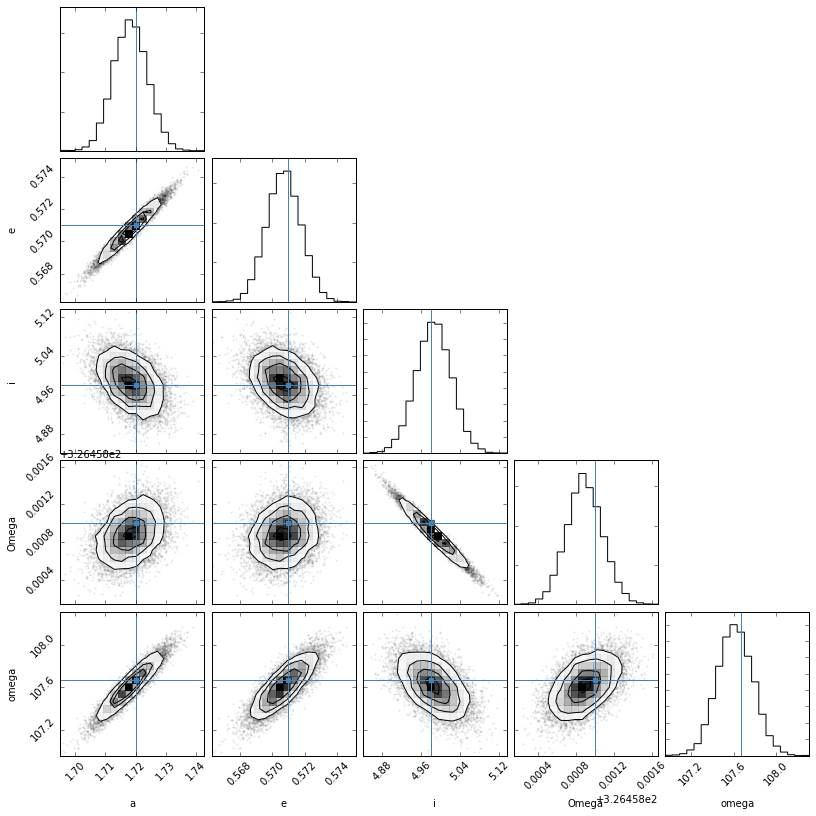

In [242]:
figure = corner.corner(samples, truths=[1.72,0.571,4.98,326.459,107.67],labels=["a","e","i","Omega","omega"])